# Continuous Control

---

In this notebook, We will learn how to train agent using ddpg algorithm for Reacher game build on Unity framework.

### 1. Set up the Reacher Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher_Windows_x86_64\\Reacher.exe")
```

In [ ]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64\\Reacher.exe')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.
- States: 33
- Actions: 4

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Method which use DDPG agent for predicting action 

Below method is used for Training and Production run. we passed ddpg agent for learning and predicting action.

In [5]:
from collections import deque
def ddpg(agent,is_training=True,n_episodes=2000, max_t=700):
    scores_deque = deque(maxlen=100)
    scores_t = []
    max_score = -np.Inf
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=is_training)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states) #np.random.randn(num_agents, action_size) # select an action (for each agent)
            #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            if is_training:
                agent.step(t,states,actions,rewards,next_states,dones)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        score = np.mean(scores)
        scores_deque.append(score)
        scores_t.append(score)
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>= 30.0 and is_training:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break
    return scores_t

### 4. Train DDPG Agent

In [6]:
from ddpg_agent import Agent
agent= Agent(state_size=states.shape[1], action_size=action_size, random_seed=10,device=device)

state = env.reset()
agent.reset()
scores = ddpg(agent,is_training=True,n_episodes=10000,max_t=1000)

C:\ProgramData\Anaconda2\envs\new-udacity\lib\site-packages\torch\nn\functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 50	Average Score: 2.18 Score: 2.18
Episode 100	Average Score: 4.56 Score: 4.56
Episode 150	Average Score: 9.67e Score: 9.67
Episode 200	Average Score: 19.33 Score: 19.33
Episode 247	Score: 39.00	Average Score: 30.02
Environment solved in 147 episodes!	Average Score: 30.02


<IPython.core.display.Javascript object>


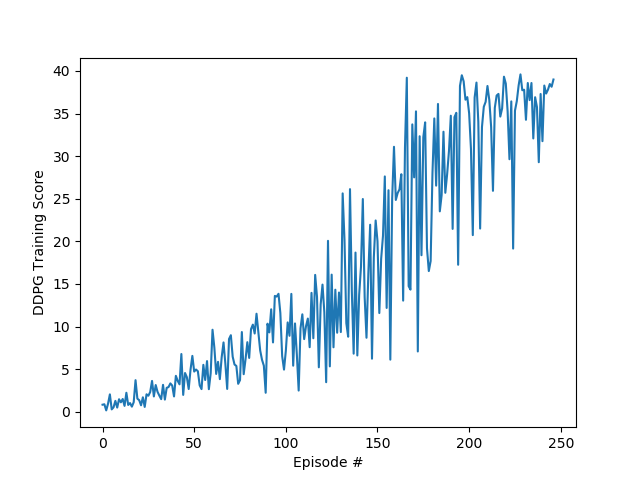

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('DDPG Training Score')
plt.xlabel('Episode #')
plt.show()

### 5. Use Trained DDPG Agent for predicting action for production run

In [10]:
from ddpg_agent import Agent
agent= Agent(state_size=states.shape[1], action_size=action_size, random_seed=10,device=device)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))

state = env.reset()
agent.reset()
scores_production = ddpg(agent,is_training=False,n_episodes=100,max_t=1000)

C:\ProgramData\Anaconda2\envs\new-udacity\lib\site-packages\torch\nn\functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 50	Average Score: 35.38 Score: 35.38
Episode 100	Average Score: 35.48 Score: 35.48


<IPython.core.display.Javascript object>


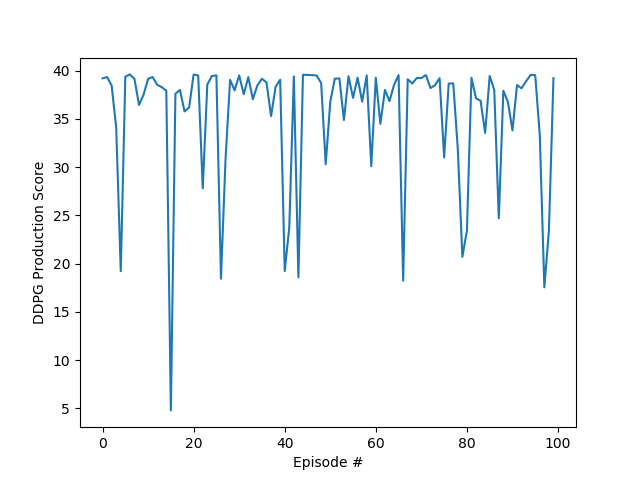

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_production)), scores_production)
plt.ylabel('DDPG Production Score')
plt.xlabel('Episode #')
plt.show()

### 4. Close Environment

In [ ]:
env.close()